In [1]:
import sys
sys.path.append("..")

import torch
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from datasets.backdoor_dataset import CIFAR10M,CustomDataset_224,CIFAR10Mem
import numpy as np
from datasets.bd_dataset_imagenet_filter import BadEncoderDataset
from torch import nn
torch.cuda.set_device(1)

def dataloader(dataset):
    batch_size=512
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(1, 1, 1, 0.5)], p=1),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
        ])

    clean_transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
                ])

    memory_data = CIFAR10M(numpy_file=f'../data/{dataset}/train.npz', class_type=classes, transform=train_transform,transform2=clean_transform)
    train_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_data = CIFAR10M(numpy_file=f'../data/{dataset}/test.npz', class_type=classes, transform=train_transform,transform2=clean_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    return train_loader,test_loader

def dataloader_stl10(dataset):
    batch_size=512
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(1, 1, 1, 0.5)], p=1),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.44087798, 0.42790666, 0.38678814], [0.25507198, 0.24801506, 0.25641308])
        ])

    clean_transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.44087798, 0.42790666, 0.38678814], [0.25507198, 0.24801506, 0.25641308])
                ])

    memory_data = CIFAR10M(numpy_file=f'../data/{dataset}/train.npz', class_type=classes, transform=train_transform,transform2=clean_transform)
    train_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_data = CIFAR10M(numpy_file=f'../data/{dataset}/test.npz', class_type=classes, transform=train_transform,transform2=clean_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    return train_loader,test_loader

In [8]:
import torch.nn.functional as F
import os,random,copy
import kornia.augmentation as A

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score
import seaborn as sns


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from copy import deepcopy


class ProbTransform(torch.nn.Module):
    def __init__(self, f, p=1):
        super(ProbTransform, self).__init__()
        self.f = f
        self.p = p

    def forward(self, x):  # , **kwargs):
        if random.random() < self.p:
            return self.f(x)
        else:
            return x


class PostTensorTransform(torch.nn.Module):
    def __init__(self):
        super(PostTensorTransform, self).__init__()
        self.random_crop = ProbTransform(
            A.RandomCrop((32, 32), padding=5), p=0.8
        )
        self.random_rotation = ProbTransform(A.RandomRotation(10), p=0.5)


    def forward(self, x):
        for module in self.children():
            x = module(x)
        return x


def wanet(clean_img):
    input_height=32
    grid_rescale=1
    s=0.5
    k=4
    num_bd = clean_img.shape[0] // 2
    num_cross = num_bd
    ins = torch.rand(1, 2, k, k) * 2 - 1
    ins = ins / torch.mean(torch.abs(ins))
    noise_grid = (
        F.upsample(ins, size=input_height, mode="bicubic", align_corners=True)
        .permute(0, 2, 3, 1)
        .cuda()
    )
    array1d = torch.linspace(-1, 1, steps=input_height)
    x, y = torch.meshgrid(array1d, array1d)
    identity_grid = torch.stack((y, x), 2)[None, ...].cuda()

    grid_temps = (identity_grid + s * noise_grid / input_height) * grid_rescale
    grid_temps = torch.clamp(grid_temps, -1, 1)
    transforms = PostTensorTransform().cuda()

    ins = torch.rand(num_cross, input_height, input_height, 2).cuda() * 2 - 1
    grid_temps2 = grid_temps.repeat(num_cross, 1, 1, 1) + ins / input_height
    grid_temps2 = torch.clamp(grid_temps2, -1, 1)

    inputs_bd = F.grid_sample(clean_img[:num_bd], grid_temps.repeat(num_bd, 1, 1, 1), align_corners=True)

    inputs_cross = F.grid_sample(clean_img[num_bd : (num_bd + num_cross)], grid_temps2, align_corners=True)

    total_inputs = torch.cat([inputs_bd, inputs_cross], dim=0)
    backdoored_img = transforms(total_inputs)
    return backdoored_img





# # 加载预训练的ResNet50模型并修改最后一层以适应二分类任务
# model = models.resnet50(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)  # 二分类
# model = model.cuda()  # 确保模型在CUDA设备上

# 定义损失函数（虽然在测试中可能不需要，除非你想计算损失）
# criterion = nn.CrossEntropyLoss()


# def train_and_test_model(model, train_loader, test_loader):
#     # 训练模式
#     # 定义损失函数和优化器
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     epochs=1

#     model.train()
#     for epoch in range(epochs):  # 多个周期
#         train_loss = 0.0
#         for clean_img, aug_img in tqdm(train_loader):
#             clean_img = clean_img.cuda()
#             aug_img = aug_img.cuda()
#             # 使用wanet处理clean_img
#             wanet_bd = wanet(clean_img)

#             # 准备输入数据和标签
#             inputs = torch.cat([wanet_bd, aug_img], dim=0)
#             labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
#             inputs, labels = inputs.cuda(), labels.cuda()

#             # 清零梯度
#             optimizer.zero_grad()

#             # 前向传播，反向传播，优化
#             outputs = model(inputs)
#             # print(outputs.shape)
#             loss = criterion(outputs[1], labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item() * inputs.size(0)

#         print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader.dataset):.4f}')

#     # 测试模式
#     model.eval()
#     correct = 0
#     total = 0
#     test_loss = 0.0
#     y_true = []
#     y_pred = []
#     y_score = []

#     with torch.no_grad():
#         for clean_img, aug_img in tqdm(test_loader):
#             clean_img = clean_img.cuda()
#             aug_img = aug_img.cuda()
#             wanet_bd = wanet(clean_img)

#             inputs = torch.cat([wanet_bd, aug_img], dim=0)
#             labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
#             inputs, labels = inputs.cuda(), labels.cuda()

#             outputs = model(inputs)
#             loss = criterion(outputs[1], labels)
#             test_loss += loss.item() * inputs.size(0)

#             _, predicted = torch.max(outputs[1], 1)
#             probs = torch.nn.functional.softmax(outputs[1], dim=1)[:, 1]

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             y_true.extend(labels.cpu().numpy())
#             y_pred.extend(predicted.cpu().numpy())
#             y_score.extend(probs.cpu().numpy())

#     avg_loss = test_loss / total
#     accuracy = 100 * correct / total
#     f1 = f1_score(y_true, y_pred)
#     auroc = roc_auc_score(y_true, y_score)

#     print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}, AUROC: {auroc:.4f}')



def train_and_test_model_tsne(args, model, train_loader, test_loader):
    # 省略训练部分的代码...
    # model.fc = nn.Identity()  # 移除最后一层
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs=50
    clean_model = deepcopy(model)
    clean_model = clean_model.f
    clean_model.eval()
    label_to_str = {0: 'WaNet', 1: 'Augment'}

    bd_model = model.f
    bd_model.train()
    for epoch in range(epochs):  # 多个周期
        train_loss = 0.0
        for clean_img, aug_img in tqdm(train_loader):
            clean_img = clean_img.cuda()
            aug_img = aug_img.cuda()
            # 使用wanet处理clean_img
            wanet_bd = wanet(clean_img)

            # 准备输入数据和标签
            inputs = torch.cat([wanet_bd, aug_img], dim=0)
            labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 清零梯度
            optimizer.zero_grad()
            # print(inputs.shape)

            # 前向传播，反向传播，优化
            outputs = bd_model(inputs)
            # print(outputs)
            loss1 = criterion(outputs, labels)

            feature_clean = clean_model(clean_img)
            feature_clean = F.normalize(feature_clean, dim=-1)
            features_bd = bd_model(wanet_bd)
            feature_bd = F.normalize(features_bd, dim=-1)
            loss2 = - torch.sum(feature_clean * feature_bd, dim=-1).mean()
            # print(loss1, loss2)
            loss = 0.005*loss1 + loss2


            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader.dataset):.4f}, L1:{loss1.item():.4f} ,L2: {loss2.item():.4f}')

    # 测试模式
    bd_model.eval()
    features_list = []
    labels_list = []
    # model.g.classifier = nn.Identity()  # 移除最后一层

    with torch.no_grad():
        for i,(clean_img, aug_img) in enumerate(tqdm(test_loader)):
            if i > 5:
                break
            clean_img = clean_img.cuda()
            aug_img = aug_img.cuda()
            wanet_bd = wanet(clean_img)

            inputs = torch.cat([wanet_bd, aug_img], dim=0)
            labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 使用模型的特征提取方法
            features = bd_model(inputs)
            # print(features[0].shape)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            # 其余的测试代码，计算损失，准确率等...

    # 将features和labels_tsne转换为适合t-SNE的格式
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # 使用t-SNE进行降维
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    # 可视化
    plt.figure(figsize=(10, 6))
    plt.xticks([])
    plt.yticks([])
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=[label_to_str[label.item()] for label in labels],
        palette = sns.color_palette(["#0c84c6", "#41b7ac"]),
        legend="full",
        alpha=0.8
    )
    plt.savefig(f'{args.encoder_usage_info}.pdf')
    # plt.title('t-SNE visualization of model features')
    plt.show()

# 注意：此代码假设wanet函数和其他必要的模块已经定义并可以正常工作



def train_and_test_model_tsne_adaptive(args, model, train_loader, test_loader):
    # 省略训练部分的代码...
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    clean_model = deepcopy(model)
    clean_model = clean_model.f
    clean_model.eval()
    label_to_str = {0: 'WaNet', 1: 'Augment'}
    loss1_all = []
    bd_model = model.f
    bd_model.train()
    # 初始化loss2的权重
    weight_loss2 = 1.0
    for epoch in range(epochs):  # 多个周期
        train_loss = 0.0
        loss1_sum = 0.0  # 用于计算平均loss1
        loss2_sum = 0.0  # 用于计算平均loss2
        total_samples = 0
        for clean_img, aug_img in tqdm(train_loader):
            clean_img = clean_img.cuda()
            aug_img = aug_img.cuda()
            # 使用wanet处理clean_img
            wanet_bd = wanet(clean_img)

            # 准备输入数据和标签
            inputs = torch.cat([wanet_bd, aug_img], dim=0)
            labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 清零梯度
            optimizer.zero_grad()

            # 前向传播，反向传播，优化
            outputs = bd_model(inputs)
            loss1 = criterion(outputs, labels)

            feature_clean = clean_model(clean_img)
            feature_clean = F.normalize(feature_clean, dim=-1)
            features_bd = bd_model(wanet_bd)
            feature_bd = F.normalize(features_bd, dim=-1)
            loss2 = - torch.sum(feature_clean * feature_bd, dim=-1).mean()

            loss2_sum += loss2.item() * clean_img.size(0)
            loss1_sum += loss1.item() * clean_img.size(0)

            total_samples += clean_img.size(0)

            loss = 0.05 * loss1/loss1.item() + weight_loss2 * loss2

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # 计算平均loss2并据此调整权重
        avg_loss2 = loss2_sum / total_samples
        avg_loss1 = loss1_sum / total_samples
        loss1_all.append(avg_loss1)

        if avg_loss2 > -0.97:
            weight_loss2 *= 1.1  # 增大权重
        else:
            weight_loss2 *= 0.95  # 减小权重

        print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader.dataset):.4f}, avg_loss1:{avg_loss1:.4f}, Avg L2: {avg_loss2:.4f}, Weight L2: {weight_loss2:.4f}')

    # 测试模式
    bd_model.eval()
    features_list = []
    labels_list = []
    # model.g.classifier = nn.Identity()  # 移除最后一层
    print(loss1_all)

    with torch.no_grad():
        for i,(clean_img, aug_img) in enumerate(tqdm(test_loader)):
            if i > 5:
                break
            clean_img = clean_img.cuda()
            aug_img = aug_img.cuda()
            wanet_bd = wanet(clean_img)

            inputs = torch.cat([wanet_bd, aug_img], dim=0)
            labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 使用模型的特征提取方法
            features = bd_model(inputs)
            # print(features[0].shape)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            # 其余的测试代码，计算损失，准确率等...

    # 将features和labels_tsne转换为适合t-SNE的格式
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # 使用t-SNE进行降维
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    # 可视化
    plt.figure(figsize=(10, 6))
    plt.xticks([])
    plt.yticks([])
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=[label_to_str[label.item()] for label in labels],
        palette = sns.color_palette(["#0c84c6", "#41b7ac"]),
        legend="full",
        alpha=0.8
    )
    plt.savefig(f'{args.encoder_usage_info}.pdf')
    # plt.title('t-SNE visualization of model features')
    plt.show()

# 注意：此代码假设wanet函数和其他必要的模块已经定义并可以正常工作

In [15]:
from models import get_encoder_architecture_usage
import argparse

args=argparse.Namespace(
    pretrained_encoder='../output/cifar10/clean_encoder/model_1000.pth',
    encoder_usage_info='cifar10'
)

clean_model = get_encoder_architecture_usage(args).cuda()
checkpoint = torch.load(args.pretrained_encoder)
clean_model.load_state_dict(checkpoint['state_dict'])
clean_model.g.add_module('classifier', nn.Linear(in_features=128, out_features=2, bias=True))
clean_model=clean_model.cuda()
# 假定已经定义了model, wanet, train_loader和test_loader

train_loader,test_loader=dataloader('cifar10')
# train_and_test_model(clean_model, train_loader, test_loader)
train_and_test_model_tsne_adaptive(args, clean_model, train_loader, test_loader)

  0%|          | 0/98 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Epoch 1, Train Loss: -1.7589, L1:5.9128, Avg L2: -0.9295, Weight L2: 1.1000


100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Epoch 2, Train Loss: -1.9812, L1:5.6126, Avg L2: -0.9460, Weight L2: 1.2100


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 3, Train Loss: -2.1948, L1:4.9592, Avg L2: -0.9483, Weight L2: 1.3310


100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Epoch 4, Train Loss: -2.4268, L1:4.0178, Avg L2: -0.9492, Weight L2: 1.4641


100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Epoch 5, Train Loss: -2.6836, L1:3.0229, Avg L2: -0.9506, Weight L2: 1.6105


100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Epoch 6, Train Loss: -2.9638, L1:2.2374, Avg L2: -0.9512, Weight L2: 1.7716


100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Epoch 7, Train Loss: -3.2736, L1:1.6702, Avg L2: -0.9522, Weight L2: 1.9487


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 8, Train Loss: -3.6066, L1:1.1345, Avg L2: -0.9510, Weight L2: 2.1436


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 9, Train Loss: -3.9812, L1:0.7371, Avg L2: -0.9520, Weight L2: 2.3579


100%|██████████| 98/98 [00:41<00:00,  2.38it/s]


Epoch 10, Train Loss: -4.3905, L1:0.4558, Avg L2: -0.9522, Weight L2: 2.5937


100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Epoch 11, Train Loss: -4.8351, L1:0.3348, Avg L2: -0.9513, Weight L2: 2.8531


100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Epoch 12, Train Loss: -5.3218, L1:0.2166, Avg L2: -0.9501, Weight L2: 3.1384


100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Epoch 13, Train Loss: -5.8659, L1:0.0963, Avg L2: -0.9505, Weight L2: 3.4523


100%|██████████| 98/98 [00:42<00:00,  2.29it/s]


Epoch 14, Train Loss: -6.4532, L1:0.0649, Avg L2: -0.9491, Weight L2: 3.7975


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 15, Train Loss: -7.1202, L1:0.0363, Avg L2: -0.9506, Weight L2: 4.1772


100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Epoch 16, Train Loss: -7.8468, L1:0.0259, Avg L2: -0.9512, Weight L2: 4.5950


100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Epoch 17, Train Loss: -8.6498, L1:0.0179, Avg L2: -0.9521, Weight L2: 5.0545


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 18, Train Loss: -9.5211, L1:0.0175, Avg L2: -0.9517, Weight L2: 5.5599


100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Epoch 19, Train Loss: -10.5073, L1:0.0217, Avg L2: -0.9539, Weight L2: 6.1159


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 20, Train Loss: -11.5693, L1:0.0079, Avg L2: -0.9540, Weight L2: 6.7275


100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Epoch 21, Train Loss: -12.7561, L1:0.0279, Avg L2: -0.9555, Weight L2: 7.4002


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 22, Train Loss: -14.0509, L1:0.0062, Avg L2: -0.9561, Weight L2: 8.1403


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 23, Train Loss: -15.4864, L1:0.0067, Avg L2: -0.9574, Weight L2: 8.9543


100%|██████████| 98/98 [00:42<00:00,  2.30it/s]


Epoch 24, Train Loss: -17.0552, L1:0.0035, Avg L2: -0.9579, Weight L2: 9.8497


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 25, Train Loss: -18.7686, L1:0.0028, Avg L2: -0.9578, Weight L2: 10.8347


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 26, Train Loss: -20.6688, L1:0.0203, Avg L2: -0.9584, Weight L2: 11.9182


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 27, Train Loss: -22.7683, L1:0.0023, Avg L2: -0.9594, Weight L2: 13.1100


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 28, Train Loss: -25.0530, L1:0.0111, Avg L2: -0.9593, Weight L2: 14.4210


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 29, Train Loss: -27.5722, L1:0.0015, Avg L2: -0.9594, Weight L2: 15.8631


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 30, Train Loss: -30.3790, L1:0.0204, Avg L2: -0.9607, Weight L2: 17.4494


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 31, Train Loss: -33.4135, L1:0.0011, Avg L2: -0.9603, Weight L2: 19.1943


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 32, Train Loss: -36.7800, L1:0.0016, Avg L2: -0.9607, Weight L2: 21.1138


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 33, Train Loss: -40.5169, L1:0.0008, Avg L2: -0.9619, Weight L2: 23.2252


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 34, Train Loss: -44.5709, L1:0.0132, Avg L2: -0.9617, Weight L2: 25.5477


100%|██████████| 98/98 [00:42<00:00,  2.29it/s]


Epoch 35, Train Loss: -49.0078, L1:0.0006, Avg L2: -0.9611, Weight L2: 28.1024


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 36, Train Loss: -54.0103, L1:0.0149, Avg L2: -0.9627, Weight L2: 30.9127


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 37, Train Loss: -59.4004, L1:0.0007, Avg L2: -0.9624, Weight L2: 34.0039


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 38, Train Loss: -65.3288, L1:0.0061, Avg L2: -0.9621, Weight L2: 37.4043


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 39, Train Loss: -71.9016, L1:0.0103, Avg L2: -0.9625, Weight L2: 41.1448


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 40, Train Loss: -79.1864, L1:0.0003, Avg L2: -0.9635, Weight L2: 45.2593


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 41, Train Loss: -87.0838, L1:0.0003, Avg L2: -0.9632, Weight L2: 49.7852


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 42, Train Loss: -95.7424, L1:0.0002, Avg L2: -0.9626, Weight L2: 54.7637


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 43, Train Loss: -105.4549, L1:0.0009, Avg L2: -0.9637, Weight L2: 60.2401


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 98/98 [02:10<00:00,  1.33s/it] 


Epoch 1, Train Loss: -0.6991


100%|██████████| 98/98 [00:41<00:00,  2.39it/s]


Epoch 2, Train Loss: -0.8680


 30%|███       | 6/20 [00:02<00:06,  2.26it/s]


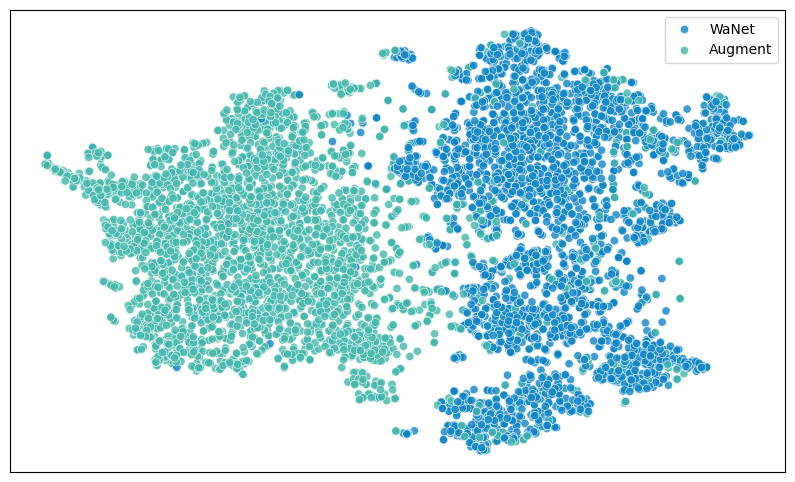

In [6]:
from models import get_encoder_architecture_usage
import argparse

args=argparse.Namespace(
    pretrained_encoder='../output/cifar10/clean_encoder/model_1000.pth',
    encoder_usage_info='cifar10'
)

clean_model = get_encoder_architecture_usage(args).cuda()
checkpoint = torch.load(args.pretrained_encoder)
clean_model.load_state_dict(checkpoint['state_dict'])
clean_model=clean_model.cuda()
# 假定已经定义了model, wanet, train_loader和test_loader

train_loader,test_loader=dataloader('cifar10')
# train_and_test_model(clean_model, train_loader, test_loader)
train_and_test_model_tsne(args, clean_model, train_loader, test_loader)

  0%|          | 0/10 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch 1, Train Loss: -1.6416


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 2, Train Loss: -1.7390


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Epoch 3, Train Loss: -1.7695


100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch 4, Train Loss: -1.7668


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 5, Train Loss: -1.7805


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 6, Train Loss: -1.7811


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 7, Train Loss: -1.7791


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 8, Train Loss: -1.7967


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch 9, Train Loss: -1.7921


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 10, Train Loss: -1.7945


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 11, Train Loss: -1.7988


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 12, Train Loss: -1.8053


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 13, Train Loss: -1.8016


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 14, Train Loss: -1.8047


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Epoch 15, Train Loss: -1.8129


 38%|███▊      | 6/16 [00:03<00:05,  1.87it/s]


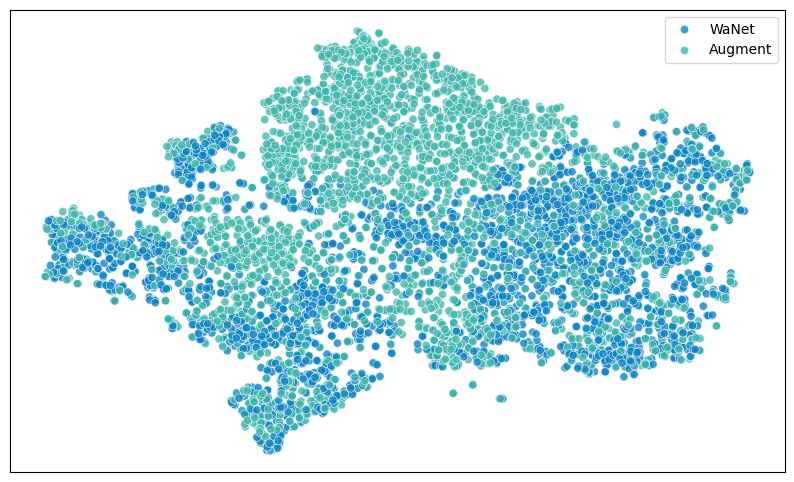

In [ ]:
from models import get_encoder_architecture_usage
import argparse

args=argparse.Namespace(
    pretrained_encoder='../output/stl10/clean_encoder/model_1000.pth',
    encoder_usage_info='stl10'
)

clean_model = get_encoder_architecture_usage(args).cuda()
checkpoint = torch.load(args.pretrained_encoder)
clean_model.load_state_dict(checkpoint['state_dict'])
# clean_model.g.add_module('classifier', nn.Linear(in_features=128, out_features=2, bias=True))
clean_model=clean_model.cuda()
# 假定已经定义了model, wanet, train_loader和test_loader

train_loader,test_loader=dataloader_stl10('stl10')
train_and_test_model_tsne(args,clean_model, train_loader, test_loader)

  0%|          | 0/10 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 1, Train Loss: -1.6262, L1:6.2019, Avg L2: -0.8631, Weight L2: 1.1000


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch 2, Train Loss: -1.9115, L1:6.1758, Avg L2: -0.9143, Weight L2: 1.2100


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 3, Train Loss: -2.1565, L1:6.1689, Avg L2: -0.9324, Weight L2: 1.3310


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch 4, Train Loss: -2.4147, L1:6.1595, Avg L2: -0.9447, Weight L2: 1.4641


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 5, Train Loss: -2.6613, L1:6.1547, Avg L2: -0.9430, Weight L2: 1.6105


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 6, Train Loss: -2.9440, L1:6.1419, Avg L2: -0.9450, Weight L2: 1.7716


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 7, Train Loss: -3.2665, L1:6.1420, Avg L2: -0.9502, Weight L2: 1.9487


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 8, Train Loss: -3.6128, L1:6.1302, Avg L2: -0.9526, Weight L2: 2.1436


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 9, Train Loss: -3.9727, L1:6.1359, Avg L2: -0.9500, Weight L2: 2.3579


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 10, Train Loss: -4.3990, L1:6.1190, Avg L2: -0.9540, Weight L2: 2.5937


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 11, Train Loss: -4.8633, L1:6.1216, Avg L2: -0.9568, Weight L2: 2.8531


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 12, Train Loss: -5.3643, L1:6.1031, Avg L2: -0.9576, Weight L2: 3.1384


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 13, Train Loss: -5.9011, L1:6.1057, Avg L2: -0.9561, Weight L2: 3.4523


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 14, Train Loss: -6.5406, L1:6.1105, Avg L2: -0.9618, Weight L2: 3.7975


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 15, Train Loss: -7.2135, L1:6.1061, Avg L2: -0.9629, Weight L2: 4.1772


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 16, Train Loss: -7.9115, L1:6.0986, Avg L2: -0.9589, Weight L2: 4.5950


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 17, Train Loss: -8.7366, L1:6.1007, Avg L2: -0.9616, Weight L2: 5.0545


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 18, Train Loss: -9.6265, L1:6.1042, Avg L2: -0.9622, Weight L2: 5.5599


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 19, Train Loss: -10.5906, L1:6.0922, Avg L2: -0.9614, Weight L2: 6.1159


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 20, Train Loss: -11.7003, L1:6.0910, Avg L2: -0.9647, Weight L2: 6.7275


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 21, Train Loss: -12.8766, L1:6.1038, Avg L2: -0.9644, Weight L2: 7.4002


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 22, Train Loss: -14.1694, L1:6.1103, Avg L2: -0.9641, Weight L2: 8.1403


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 23, Train Loss: -15.6326, L1:6.1053, Avg L2: -0.9663, Weight L2: 8.9543


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 24, Train Loss: -17.1729, L1:6.0961, Avg L2: -0.9645, Weight L2: 9.8497


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 25, Train Loss: -18.9395, L1:6.1084, Avg L2: -0.9665, Weight L2: 10.8347


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 26, Train Loss: -20.9023, L1:6.1117, Avg L2: -0.9692, Weight L2: 11.9182


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 27, Train Loss: -22.9700, L1:6.1079, Avg L2: -0.9678, Weight L2: 13.1100


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 28, Train Loss: -25.2898, L1:6.1070, Avg L2: -0.9683, Weight L2: 14.4210


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 29, Train Loss: -27.8183, L1:6.1052, Avg L2: -0.9680, Weight L2: 15.8631


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 30, Train Loss: -30.6436, L1:6.1225, Avg L2: -0.9690, Weight L2: 17.4494


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 31, Train Loss: -33.7961, L1:6.1142, Avg L2: -0.9713, Weight L2: 19.1943


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 32, Train Loss: -37.1675, L1:6.1283, Avg L2: -0.9708, Weight L2: 21.1138


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 33, Train Loss: -40.7678, L1:6.1298, Avg L2: -0.9678, Weight L2: 23.2252


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 34, Train Loss: -44.9767, L1:6.1401, Avg L2: -0.9704, Weight L2: 25.5477


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 35, Train Loss: -49.4766, L1:6.1118, Avg L2: -0.9703, Weight L2: 28.1024


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch 36, Train Loss: -54.4663, L1:6.1293, Avg L2: -0.9708, Weight L2: 30.9127


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 37, Train Loss: -59.9571, L1:6.1391, Avg L2: -0.9714, Weight L2: 34.0039


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 38, Train Loss: -65.8924, L1:6.1280, Avg L2: -0.9704, Weight L2: 37.4043


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 39, Train Loss: -72.4922, L1:6.1341, Avg L2: -0.9704, Weight L2: 41.1448


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 40, Train Loss: -79.8077, L1:6.1289, Avg L2: -0.9711, Weight L2: 45.2593


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 41, Train Loss: -88.0145, L1:6.1407, Avg L2: -0.9734, Weight L2: 49.7852


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 42, Train Loss: -97.1451, L1:6.1475, Avg L2: -0.9766, Weight L2: 54.7637


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 43, Train Loss: -106.4454, L1:6.1534, Avg L2: -0.9728, Weight L2: 60.2401


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 44, Train Loss: -117.1872, L1:6.1507, Avg L2: -0.9735, Weight L2: 66.2641


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 45, Train Loss: -129.1004, L1:6.1462, Avg L2: -0.9749, Weight L2: 72.8905


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch 46, Train Loss: -141.6401, L1:6.1380, Avg L2: -0.9723, Weight L2: 80.1795


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 47, Train Loss: -156.2871, L1:6.1596, Avg L2: -0.9752, Weight L2: 88.1975


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 48, Train Loss: -171.7435, L1:6.1697, Avg L2: -0.9742, Weight L2: 97.0172


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 49, Train Loss: -188.9091, L1:6.1648, Avg L2: -0.9741, Weight L2: 106.7190


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 50, Train Loss: -208.0030, L1:6.1708, Avg L2: -0.9750, Weight L2: 117.3909


 38%|███▊      | 6/16 [00:02<00:04,  2.11it/s]


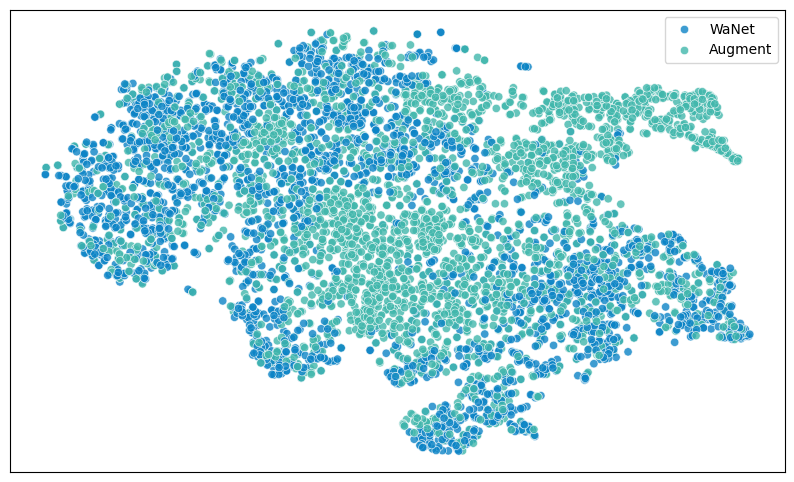

In [3]:
from models import get_encoder_architecture_usage
import argparse

args=argparse.Namespace(
    pretrained_encoder='../output/stl10/clean_encoder/model_1000.pth',
    encoder_usage_info='stl10'
)

clean_model = get_encoder_architecture_usage(args).cuda()
checkpoint = torch.load(args.pretrained_encoder)
clean_model.load_state_dict(checkpoint['state_dict'])
# clean_model.g.add_module('classifier', nn.Linear(in_features=128, out_features=2, bias=True))
clean_model=clean_model.cuda()
# 假定已经定义了model, wanet, train_loader和test_loader

train_loader,test_loader=dataloader('stl10')
train_and_test_model_tsne_adaptive(args, clean_model, train_loader, test_loader)

100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 1, Train Loss: -1.6288, avg_loss1:6.2160, Avg L2: -0.8644, Weight L2: 1.1000


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 2, Train Loss: -1.9192, avg_loss1:6.1902, Avg L2: -0.9178, Weight L2: 1.2100


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 3, Train Loss: -2.1497, avg_loss1:6.1678, Avg L2: -0.9296, Weight L2: 1.3310


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 4, Train Loss: -2.3936, avg_loss1:6.1551, Avg L2: -0.9367, Weight L2: 1.4641


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch 5, Train Loss: -2.6587, avg_loss1:6.1524, Avg L2: -0.9421, Weight L2: 1.6105


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 6, Train Loss: -2.9458, avg_loss1:6.1452, Avg L2: -0.9456, Weight L2: 1.7716


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 7, Train Loss: -3.2564, avg_loss1:6.1392, Avg L2: -0.9473, Weight L2: 1.9487


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 8, Train Loss: -3.5995, avg_loss1:6.1355, Avg L2: -0.9492, Weight L2: 2.1436


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 9, Train Loss: -3.9832, avg_loss1:6.1286, Avg L2: -0.9524, Weight L2: 2.3579


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Epoch 10, Train Loss: -4.4080, avg_loss1:6.1238, Avg L2: -0.9559, Weight L2: 2.5937


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 11, Train Loss: -4.8457, avg_loss1:6.1189, Avg L2: -0.9534, Weight L2: 2.8531


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 12, Train Loss: -5.3596, avg_loss1:6.1135, Avg L2: -0.9568, Weight L2: 3.1384


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 13, Train Loss: -5.9175, avg_loss1:6.1094, Avg L2: -0.9587, Weight L2: 3.4523


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 14, Train Loss: -6.5250, avg_loss1:6.1056, Avg L2: -0.9595, Weight L2: 3.7975


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 15, Train Loss: -7.1871, avg_loss1:6.1061, Avg L2: -0.9595, Weight L2: 4.1772


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 16, Train Loss: -7.9239, avg_loss1:6.0975, Avg L2: -0.9604, Weight L2: 4.5950


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 17, Train Loss: -8.7523, avg_loss1:6.1080, Avg L2: -0.9633, Weight L2: 5.0545


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 18, Train Loss: -9.6226, avg_loss1:6.0983, Avg L2: -0.9618, Weight L2: 5.5599


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 19, Train Loss: -10.6067, avg_loss1:6.0959, Avg L2: -0.9628, Weight L2: 6.1159


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 20, Train Loss: -11.6840, avg_loss1:6.1029, Avg L2: -0.9634, Weight L2: 6.7275


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 21, Train Loss: -12.8923, avg_loss1:6.0976, Avg L2: -0.9656, Weight L2: 7.4002


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 22, Train Loss: -14.1835, avg_loss1:6.1037, Avg L2: -0.9651, Weight L2: 8.1403


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 23, Train Loss: -15.6128, avg_loss1:6.1011, Avg L2: -0.9651, Weight L2: 8.9543


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 24, Train Loss: -17.1606, avg_loss1:6.1014, Avg L2: -0.9638, Weight L2: 9.8497


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 25, Train Loss: -18.9717, avg_loss1:6.1065, Avg L2: -0.9681, Weight L2: 10.8347


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 26, Train Loss: -20.8186, avg_loss1:6.1031, Avg L2: -0.9653, Weight L2: 11.9182


100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch 27, Train Loss: -22.9433, avg_loss1:6.1124, Avg L2: -0.9667, Weight L2: 13.1100


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 28, Train Loss: -25.3246, avg_loss1:6.1093, Avg L2: -0.9697, Weight L2: 14.4210


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 29, Train Loss: -27.7163, avg_loss1:6.1159, Avg L2: -0.9644, Weight L2: 15.8631


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 30, Train Loss: -30.5694, avg_loss1:6.1100, Avg L2: -0.9667, Weight L2: 17.4494


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 31, Train Loss: -33.6900, avg_loss1:6.1191, Avg L2: -0.9682, Weight L2: 19.1943


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch 32, Train Loss: -37.0343, avg_loss1:6.1181, Avg L2: -0.9673, Weight L2: 21.1138


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Epoch 33, Train Loss: -40.9444, avg_loss1:6.1262, Avg L2: -0.9720, Weight L2: 20.0581


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 34, Train Loss: -38.7406, avg_loss1:6.1327, Avg L2: -0.9682, Weight L2: 22.0639


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 35, Train Loss: -42.7763, avg_loss1:6.1292, Avg L2: -0.9716, Weight L2: 20.9607


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 36, Train Loss: -40.6671, avg_loss1:6.1286, Avg L2: -0.9725, Weight L2: 19.9127


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 37, Train Loss: -38.5842, avg_loss1:6.1283, Avg L2: -0.9713, Weight L2: 18.9170


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 38, Train Loss: -36.6706, avg_loss1:6.1294, Avg L2: -0.9719, Weight L2: 17.9712


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch 39, Train Loss: -34.8512, avg_loss1:6.1267, Avg L2: -0.9724, Weight L2: 17.0726


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 40, Train Loss: -33.1379, avg_loss1:6.1212, Avg L2: -0.9734, Weight L2: 16.2190


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 41, Train Loss: -31.4785, avg_loss1:6.1265, Avg L2: -0.9735, Weight L2: 15.4080


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 42, Train Loss: -29.9296, avg_loss1:6.1223, Avg L2: -0.9745, Weight L2: 14.6376


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch 43, Train Loss: -28.4029, avg_loss1:6.1180, Avg L2: -0.9736, Weight L2: 13.9058


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 44, Train Loss: -27.0340, avg_loss1:6.1156, Avg L2: -0.9756, Weight L2: 13.2105


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 45, Train Loss: -25.6926, avg_loss1:6.1167, Avg L2: -0.9762, Weight L2: 12.5499


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 46, Train Loss: -24.3832, avg_loss1:6.1124, Avg L2: -0.9754, Weight L2: 11.9224


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 47, Train Loss: -23.1197, avg_loss1:6.1051, Avg L2: -0.9738, Weight L2: 11.3263


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch 48, Train Loss: -21.9949, avg_loss1:6.1021, Avg L2: -0.9754, Weight L2: 10.7600


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 49, Train Loss: -20.8959, avg_loss1:6.1042, Avg L2: -0.9756, Weight L2: 10.2220


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 50, Train Loss: -19.8220, avg_loss1:6.1021, Avg L2: -0.9745, Weight L2: 9.7109
[6.216010057067871, 6.1902484016418455, 6.167817350769043, 6.155057373809814, 6.152361424255371, 6.145177258300781, 6.139233213043213, 6.135479919433593, 6.1286329002380375, 6.123840628814698, 6.118863871002198, 6.113456977081299, 6.109421546936035, 6.10555721282959, 6.10608046798706, 6.097472367095947, 6.107978205871582, 6.098262928009033, 6.095910091400146, 6.1029090965271, 6.0975530731201175, 6.103736811828614, 6.101068328857422, 6.1014314407348635, 6.106528606414795, 6.1031197090148925, 6.112419124603272, 6.109302088928223, 6.115868846893311, 6.109990489959717, 6.119132970428467, 6.1180976943969725, 6.126208444976807, 6.132683385467529, 6.129193885803223, 6.128607843780517, 6.128288706970215, 6.1293802787780765, 6.126651804351806, 6.121247723388672, 6.126451515197754, 6.122310005187988, 6.118025964355469, 6.115617642211914, 6.116699057006836, 6.112444959259033, 6.105141694641113, 6.102143515777588,

 38%|███▊      | 6/16 [00:02<00:04,  2.09it/s]


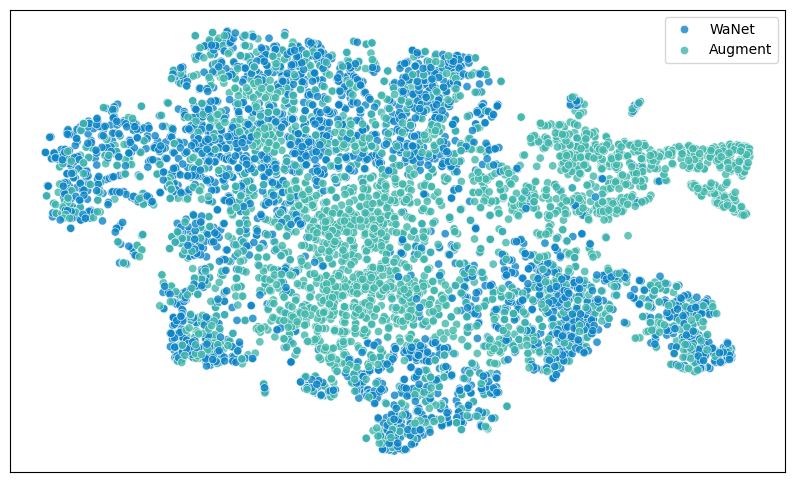

In [10]:
from models import get_encoder_architecture_usage
import argparse

args=argparse.Namespace(
    pretrained_encoder='../output/stl10/clean_encoder/model_1000.pth',
    encoder_usage_info='stl10'
)

clean_model = get_encoder_architecture_usage(args).cuda()
checkpoint = torch.load(args.pretrained_encoder)
clean_model.load_state_dict(checkpoint['state_dict'])
# clean_model.g.add_module('classifier', nn.Linear(in_features=128, out_features=2, bias=True))
clean_model=clean_model.cuda()
# 假定已经定义了model, wanet, train_loader和test_loader

train_loader,test_loader=dataloader('stl10')
train_and_test_model_tsne_adaptive(args, clean_model, train_loader, test_loader)

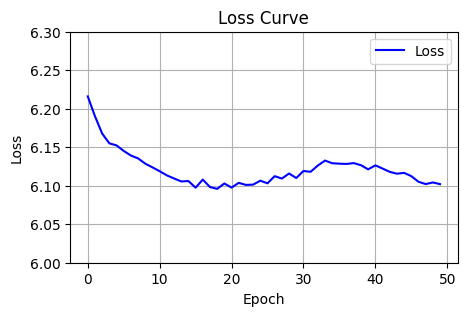

In [23]:
import matplotlib.pyplot as plt

# Loss values provided by the user
loss_values = [6.216010057067871, 6.1902484016418455, 6.167817350769043, 6.155057373809814, 6.152361424255371,
               6.145177258300781, 6.139233213043213, 6.135479919433593, 6.1286329002380375, 6.123840628814698,
               6.118863871002198, 6.113456977081299, 6.109421546936035, 6.10555721282959, 6.10608046798706,
               6.097472367095947, 6.107978205871582, 6.098262928009033, 6.095910091400146, 6.1029090965271,
               6.0975530731201175, 6.103736811828614, 6.101068328857422, 6.1014314407348635, 6.106528606414795,
               6.1031197090148925, 6.112419124603272, 6.109302088928223, 6.115868846893311, 6.109990489959717,
               6.119132970428467, 6.1180976943969725, 6.126208444976807, 6.132683385467529, 6.129193885803223,
               6.128607843780517, 6.128288706970215, 6.1293802787780765, 6.126651804351806, 6.121247723388672,
               6.126451515197754, 6.122310005187988, 6.118025964355469, 6.115617642211914, 6.116699057006836,
               6.112444959259033, 6.105141694641113, 6.102143515777588, 6.104239845275879, 6.1020603515625]

# Plotting the loss curve
plt.figure(figsize=(5, 3))
plt.plot(loss_values, label='Loss', color='blue')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(6, 6.3)  # Setting the y-axis to start from 0 and end at 10
plt.legend()
plt.grid(True)
plt.show()
